<a href="https://colab.research.google.com/github/Druvith/NN_from_scratch2023/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#OBJECT DETECTION AND BOUNDING BOXES

In [1]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [ ]:
d2l.set_figsize()
img = d2l.plt.imread('2.jpg')
d2l.plt.imshow(img)

FileNotFoundError: ignored

In [ ]:
def box_corner_to_center(boxes):
  x1, y1, x2, y2 = boxes[:,0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  cx = (x1 + y1) / 2
  cy = (y1 + y2) / 2
  w = x2 - x1
  h = y2 - y1
  boxes = torch.stack((cx, cy, w, h), axis = -1)
  return boxes

def box_center_to_corner(boxes):
  cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  x1 = cx - 0.5 * w
  y1 = cy - 0.5 * h
  x2 = cx + 0.5 * w
  y2 = cy + 0.5 * h
  boxes = torch.stack((x1, y1, x2, y2), axis=-1)
  return boxes



In [ ]:
# Here `bbox` is the abbreviation for bounding box
cat_bbox, dog_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [ ]:
boxes = torch.tensor((cat_bbox, dog_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

In [ ]:
#Anchor boxes

In [ ]:
torch.set_printoptions(2)

In [ ]:
#@save
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [ ]:
img = d2l.plt.imread('2.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))  # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

In [ ]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 240, :, :]

In [ ]:
def show_boxes(axes, bboxes, labels=None, colors=None):
   def make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
      color = colors[i % len(colors)]
      rect = d2l.bbox_to_rec(bbox.detach().numpy(), color)
      axes.add_patch(rect)
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center', fontsize=9)

In [ ]:
#Multi scale object detection

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread('2.jpg')
h, w = img.shape[:2]
h, w

(240, 360)

In [2]:
#WORD2VEC

In [2]:
import collections
import math
import os
import random
import torch
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', '319d85e578af0cdc590547f26231e4e31cdf1e42')


def read_ptb():
  data_dir = d2l.download_extract('ptb')
  with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
    raw_text = f.read()
  return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
print(len(sentences))

42069


In [4]:
vocab = d2l.Vocab(sentences, min_freq=10)
print(len(vocab))

6719


Subsampling is done for the words with high frequency (words which aren't that important)

In [5]:
def subsample(sentences, vocab):
  sentences = [[token for token in line if vocab[token] != vocab.unk]
               for line in sentences]
  counter = collections.Counter([
      token for line in sentences for token in line
  ])
  num_tokens = sum(counter.values())

  def keep(token):
    return (random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens))

  return ([[token for token in line if keep(token)] for line in sentences], counter)

subsampled, counter = subsample(sentences, vocab)

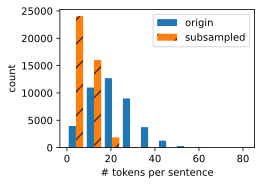

In [6]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', sentences, subsampled);

In [7]:
def compare_counts(token):
  return (f'# of "{token}": '
  f'before = {sum([l.count(token) for l in sentences])},)'
  f'after = {sum([l.count(token) for l in subsampled])}')

compare_counts('a')

'# of "a": before = 21196,)after = 1319'

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [6697, 4127, 3228, 710, 1773, 4060], [3922, 1922, 4743]]

In [9]:
sentences[:3]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group']]

In [10]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [11]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
  print('center', center, 'has contexts', context)


dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2, 3]
center 2 has contexts [1, 3]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [12]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1505664'

In [13]:
class RandomGenerator:
  def __init__(self, sampling_weights):
    self.population = list(range(1, len(sampling_weights) + 1))
    self.sampling_weights = sampling_weights
    self.candidates = []
    self.i = 0

  def draw(self):
    if self.i == len(self.candidates):
      self.candidates = random.choices(
          self.population, self.sampling_weights, k=10000
      )
      self.i = 0
    self.i +=1
    return self.candidates[self.i - 1]


In [14]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 2, 2, 3, 2, 2, 3, 1, 2, 2]

In [15]:
def get_negatives(all_contexts, vocab, counter, K):
  sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                      for i in range(1, len(vocab))]
  all_negatives, generator = [], RandomGenerator(sampling_weights)
  for contexts in all_contexts:
    negatives = []
    while len(negatives) < len(contexts) * K:
      neg = generator.draw()
      if neg not in contexts:
        negatives.append(neg)
    all_negatives.append(negatives)
  return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [27]:
#@save
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [28]:
x1 = (1, [2, 2], [3, 3, 3, 3])
x2 = (1, [2, 2, 2], [3, 3, 3])
batch = batchify((x1, x2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for names, data in zip(names, batch):
  print(names, '=', data)


centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 3]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [29]:

def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

In [32]:
data_iter, vocab = load_data_ptb(512, 5, 5)
names = ['centers', 'contexts_negatives', 'masks', 'labels']
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding weight({embed.weight.shape}, '
f'dtype={embed.weight.dtype})')

Parameter embedding weight(torch.Size([20, 4]), dtype=torch.float32)


In [4]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[ 1.7186,  0.2304,  0.7985,  1.3817],
         [ 1.7047, -2.7636, -1.0732,  1.2357],
         [ 1.4971,  0.4023,  1.1195, -1.3969]],

        [[-0.4404,  1.9132,  1.4531,  0.0938],
         [-1.4934,  0.6180, -0.0680, -1.8835],
         [ 1.3556, -0.2277,  0.9450, -1.4646]]], grad_fn=<EmbeddingBackward0>)

In [5]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
  v = embed_v(center)
  u = embed_u(contexts_and_negatives)
  pred = torch.bmm(v, u.permute(0, 2, 1))
  return pred

In [6]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [7]:
class SigmoidBCELoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, inputs, target, mask=None):
    out = nn.functional.binary_cross_entropy_with_logits(
        inputs, target, weight=mask, reduction='none')
    return out.mean(dim=1)

loss = SigmoidBCELoss()

In [8]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1]/ mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [9]:
def sigmd(x):
  return -math.log(1/ (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [10]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [11]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.367, 192585.9 tokens/sec on cuda:0


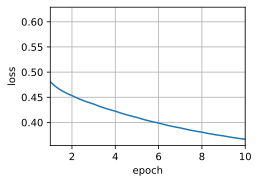

In [17]:
lr, num_epochs = 0.002, 10
train(net, data_iter, lr, num_epochs)

In [20]:
#cosine similarity

def get_similar_tokens(query_token, k, embed):
  W = embed.weight.data
  x = W[vocab[query_token]]
  cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
  topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
  for i in topk[1:]:
    print(f' cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

 cosine sim=0.549: intel
 cosine sim=0.513: microprocessor
 cosine sim=0.510: chips
